# Deseason and predict with ARIMA again


In [1]:
import pandas as pd

import numpy as np
import pmdarima as pm
from statsmodels.tsa import seasonal
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns
from matplotlib import rcParams  

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
# Load clean
raw_pd = pd.read_csv('../data/interim/trips_per_hour_dropped_na_and_all_outliers_under_001_and_over_999.csv')
raw_pd.request_date = pd.to_datetime(raw_pd.request_date)
ts = raw_pd.set_index(raw_pd.request_date)['trip_counts']
ts_df = pd.DataFrame(ts)

In [3]:
decomp = seasonal.seasonal_decompose(ts, model='multiplicative', freq=24)


<IPython.core.display.Javascript object>


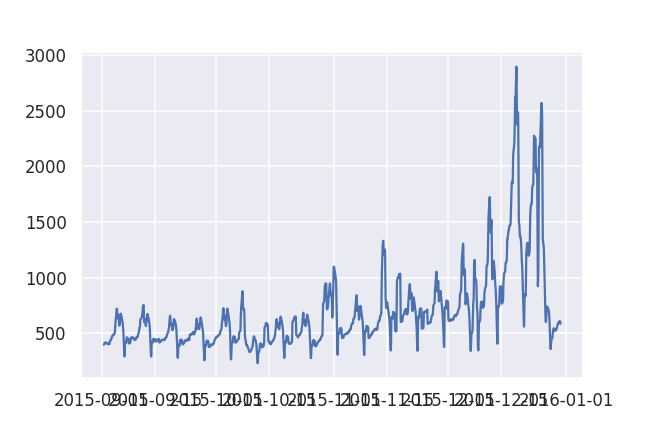

In [5]:
plt.plot(decomp.trend)
plt.show()

In [ ]:

# ## Stationarity for frequency components
# 
# Lets see how stationary the timeseries is once again, and later see if we can decompose the trend from the seasonalities.

# In[3]:


from src.models.stats_tests import test_stationarity


# In[4]:


# Initial test on data, KPSS test is not perfect, suggesting there is a non-stationary component in the series
sttest_0 = test_stationarity(ts, plot=False, method="KPSS")


# In[5]:


# Fortunately the ADF test, suggests with higher certainty that any non-stationary component can be transformed.
sttest_1 = test_stationarity(ts, plot=False, method="ADF")


# # Decomposing
# 
# Let's decompose the timeseries , by removing the hour-of-day component first and then the day-of-week.
# 
# Using a mutiplicative model and a frequency of 24 first, to decompose hour-of-day seasonality and then decompose the resulting trend even further, with frequency 7, to remove the day-of-week seasonality.

# In[8]:




# In[9]:


from src.visualization.visualize import plot_decomposition


# In[10]:


plt.plot(ts, label='Original')
plt.show()


# In[18]:


sns.distplot(decomp.trend, label='Trend')
plt.show()


# In[19]:


plt.plot(decomp.seasonal, label='Seasonality')
plt.show()


# In[20]:


plt.plot(decomp.resid, label='Residuals')
plt.show()


# In[15]:


trend = decomp.trend
trend.dropna(inplace=True)
trend.plot()
plt.show();
plt.


# In[ ]:


decomp2 = seasonal.seasonal_decompose(
    trend, model='multiplicative', freq=7*24
)
plot_decomposition(plt, decomp.trend, decomp2)
plt.show()


# In[ ]:


trend2 = decomp2.trend
trend2.dropna(inplace=True)
trend2.plot()
plt.show();


# In[ ]:


season = pd.DataFrame(decomp.seasonal)


# In[ ]:


season.plot()
plt.show()


# In[ ]:


import pmdarima as pme
trend2 = decomp2.trend
trend2.dropna(inplace=True)


# In[ ]:


n_adf = pm.arima.utils.ndiffs(trend2, test='adf')
n_kpss = pm.arima.utils.ndiffs(trend2, test='kpss')
n_pp = pm.arima.utils.ndiffs(trend2, test='pp')

(n_adf, n_kpss, n_pp)


# In[ ]:


from pmdarima.model_selection import train_test_split

season1 = decomp.seasonal.dropna()
y_train_season, y_test_season = train_test_split(season1, train_size=.85)
season1


# In[ ]:


# season_model = pm.AutoARIMA(trace=True, suppress_warnings=True, m=1)
# season_fit = season_model.fit(decomp2.trend)
season_model = pm.arima.auto_arima(decomp2.trend)


# In[ ]:


season_model = pm.auto_arima(y_train_season, start_p=1, start_q=1,
#                          test='adf',
                         max_p=3, max_q=3, m=24,
#                          start_P=0, 
                             seasonal=True,
                         d=None, D=1, 
                             trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


# In[ ]:


season_model.summary()


# In[ ]:


# Forecast
n_periods = 2
fitted, confint = season_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(decomp2.trend.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(decomp2.trend)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()


# In[ ]:


decomp2.trend.plot()
plt.show()


# In[ ]:


from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer


fit2 = Pipeline([
#     ('boxcox', BoxCoxEndogTransformer()),
    ('arima', pm.AutoARIMA(trace=True,
                           suppress_warnings=True,                    
                           D=None, alpha=0.05, d=None, error_action='warn',
                           information_criterion='aic', m=1, max_D=4, max_P=4,
                           max_Q=4, max_d=4, max_order=5, max_p=5, max_q=5,
                           maxiter=50, method='lbfgs', n_fits=10, n_jobs=1,
                           offset_test_args=None, out_of_sample_size=0,
                           random=False, random_state=None, scoring='mse',
                           scoring_args=None, seasonal=False,
                           seasonal_test='ocsb', seasonal_test_args=None,
                           start_P=2, start_Q=2, start_p=2,  
                           )
    )
])

f2 = fit2.fit(decomp2.trend)


# In[ ]:


f2.summary()


# In[ ]:


in_sample_preds, in_sample_confit = fit2.predict_in_sample(return_conf_int=True)


# In[ ]:


plt.plot(in_sample_preds)
# plt.plot(decomp2.trend)
plt.show()


# Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 32); AIC=-452.784, BIC=-440.974, Fit time=0.377 seconds

# Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 32); AIC=-454.175, BIC=-448.270, Fit time=0.046 seconds

# In[ ]:


f2.steps


# In[ ]:


import joblib
joblib.dump(f2, '../models/sunday-auto-sarima-possible-overfit')


# In[ ]:


# Forecast
n_periods = 20
fitted, confint = f2.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(decomp2.trend.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(decomp2.trend)
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("SARIMA - Final Forecast")
plt.show()


# In[ ]:




